In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import tensorflow as tf
import numpy as np
import trieste
import gpflow
import matplotlib.pyplot as plt


import gym

# env_name = "LunarLander-v2"
# env = gym.make(env_name)

# seed = 1793

# np.random.seed(seed)
# tf.random.set_seed(seed)
# env.seed(seed)

from lunar_lander.lunar_lander import LunarLander
from lunar_lander.controller import demo_heuristic_lander




from mo_penalization import MOLocalPenalizationAcquisitionFunction
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import BayesianOptimizer
from trieste.observer import OBJECTIVE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
search_space = trieste.space.Box([0.0] * 12, [1.2] * 12)

In [12]:
for _ in range(10):
    sample_w = search_space.sample(1).numpy()[0]
    demo_heuristic_lander(LunarLander(), sample_w, print_progress=False)

DemoHeuristicResult: reward: -95.88, fuel: 1.83, steps: 82.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -104.54, fuel: 0.54, steps: 60.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -56.71, fuel: 8.10, steps: 58.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -0.51, fuel: 24.06, steps: 164.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -156.28, fuel: 7.14, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.65, fuel: 0.93, steps: 48.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 54.31, fuel: 14.70, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -75.39, fuel: 10.23, steps: 73.0, crashed: True, timeout: Fa

In [48]:
reward_max = 250.0
reward_min = -350.0
fuel_factor = 100.0

N_RUNS = 10

def lander_objective(x):
    # for each point compute average reward and fuel consumed over N_RUNS runs
    all_rewards = []
    all_fuel = []
    for w in x.numpy():
        results = [demo_heuristic_lander(LunarLander(), w) for _ in range(N_RUNS)]
        all_rewards.append([r.total_reward for r in results])
        all_fuel.append([r.total_fuel for r in results])

    rewards_tensor = tf.convert_to_tensor(all_rewards, dtype=tf.float64)
    rewards_mean = tf.reshape(tf.math.reduce_mean(rewards_tensor, axis=1), (-1, 1))
    fuel_tensor = tf.convert_to_tensor(all_fuel, dtype=tf.float64)
    fuel_mean = tf.reshape(tf.math.reduce_mean(fuel_tensor, axis=1), (-1, 1))
    

    # normalizing these values is tricky
    # we want them to be between 0 and 1
    # but we have only rough idea of the min/max ranges
    # reward seems to be between -350 and 250
    # fuel is normally between 0 and 100 (actually in theory it can go to 1000*0.33=330, but this seems to never happen in practice)
    
    rewards_mean = (reward_max - rewards_mean)/(reward_max - reward_min)
    fuel_mean = fuel_mean / fuel_factor
    
    objectives_tensor = tf.concat([rewards_mean, fuel_mean], axis=-1)
    return objectives_tensor


observer = trieste.objectives.utils.mk_observer(lander_objective)

In [31]:
from trieste.models.gpflow import SparseVariational, build_svgp
from trieste.models.interfaces import TrainablePredictJointReparamModelStack
from trieste.data import Dataset

def build_stacked_independent_objectives_model(data, n_obj):
    models = []
    for idx in range(n_obj):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        svgp = build_svgp(initial_data, search_space)
        models.append((SparseVariational(svgp), 1))

    return TrainablePredictJointReparamModelStack(*models)

In [ ]:
N_STEPS = 100
num_initial_points = 2 * search_space.dimension

initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)
model = build_stacked_independent_objectives_model(initial_data, 2)

acq_fn = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_fn, num_query_points=20)

optimizer = BayesianOptimizer(observer, search_space)
result = optimizer.optimize(N_STEPS, initial_data, model, acq_rule)

In [45]:
dataset = result.try_get_final_datasets()[OBJECTIVE]

In [52]:
np.savetxt("lunar_lander/n_steps_100_n_query_points_20_observations", dataset.observations.numpy(), delimiter=',')
np.savetxt("lunar_lander/n_steps_100_n_query_points_20_query_points", dataset.query_points.numpy(), delimiter=',')

In [49]:
reward_transformed = dataset.observations[:, 0]
reward_original = reward_max - reward_transformed * (reward_max - reward_min)

fuel_transformed = dataset.observations[:, 1]
fuel_original = fuel_transformed * fuel_factor

Text(0, 0.5, 'Fuel')

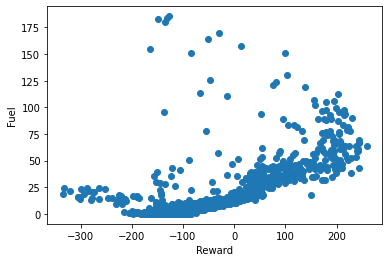

In [50]:
plt.scatter(reward_original, fuel_original)
plt.xlabel("Reward")
plt.ylabel("Fuel")